In [114]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

In [115]:
transform = transforms.Compose([transforms.ToTensor()])

In [116]:
train_data = datasets.FashionMNIST(root='/data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='/data', train=False, download=True, transform=transform)

In [117]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [118]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [119]:
class DummyAutoEncoder(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * 7 * 7),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_rec = self.decoder(z)
        return x_rec, z

In [120]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [121]:
model = DummyAutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [122]:
epochs = 10
train_losses = []
test_losses = []

In [123]:
for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0.0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, _ = model(data)
        loss = criterion(recon_batch, data)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * data.size(0)

    epoch_train_loss /= len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    model.eval()
    epoch_test_loss = 0.0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon_batch, _ = model(data)
            epoch_test_loss += criterion(recon_batch, data).item() * data.size(0)

    epoch_test_loss /= len(test_loader.dataset)
    test_losses.append(epoch_test_loss)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

Epoch 1/10, Train Loss: 0.0182, Test Loss: 0.0089
Epoch 2/10, Train Loss: 0.0072, Test Loss: 0.0063
Epoch 3/10, Train Loss: 0.0057, Test Loss: 0.0054
Epoch 4/10, Train Loss: 0.0051, Test Loss: 0.0050
Epoch 5/10, Train Loss: 0.0047, Test Loss: 0.0047
Epoch 6/10, Train Loss: 0.0045, Test Loss: 0.0046
Epoch 7/10, Train Loss: 0.0043, Test Loss: 0.0044
Epoch 8/10, Train Loss: 0.0042, Test Loss: 0.0043
Epoch 9/10, Train Loss: 0.0041, Test Loss: 0.0043
Epoch 10/10, Train Loss: 0.0040, Test Loss: 0.0041


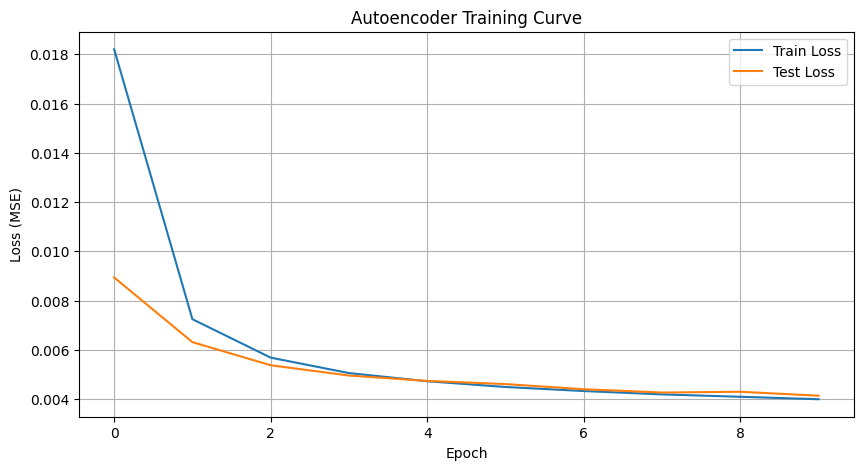

In [124]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Autoencoder Training Curve')
plt.legend()
plt.grid(True)
plt.show()

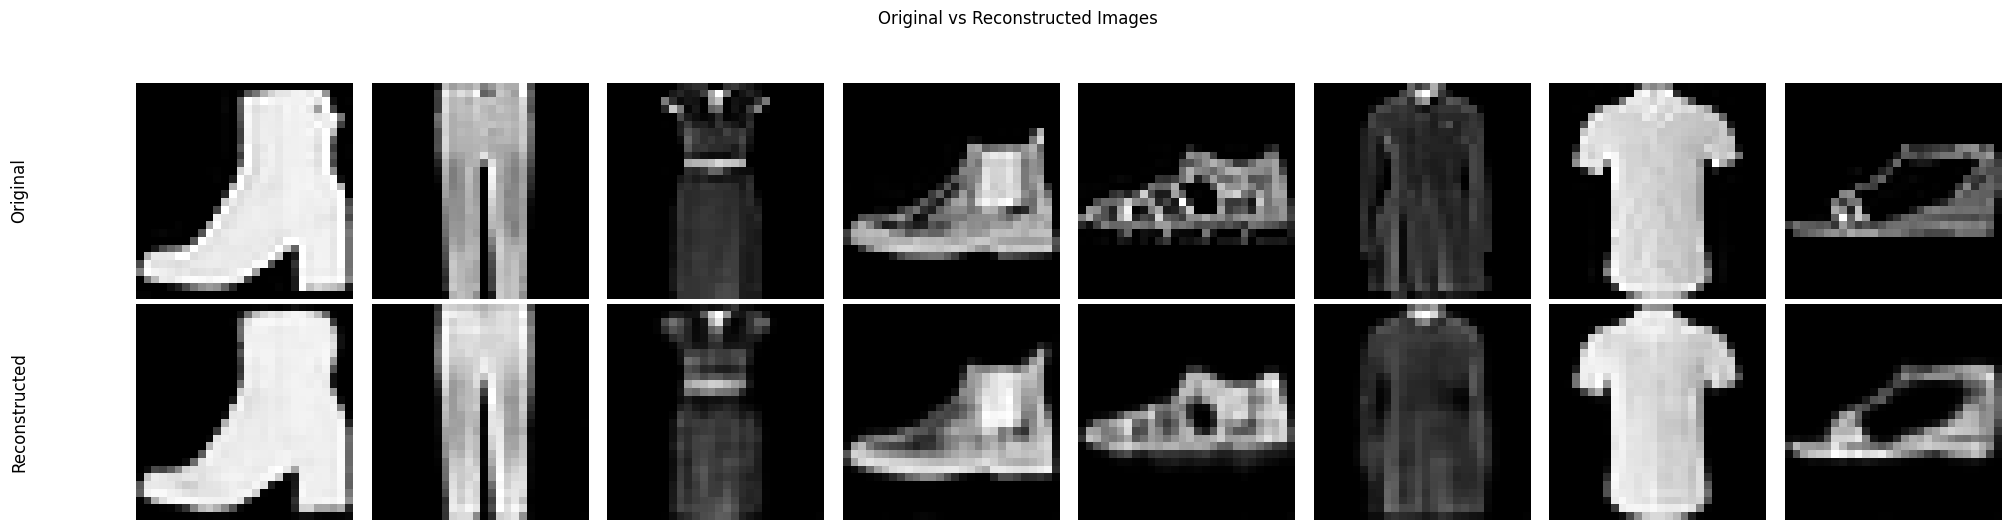

In [125]:
model.eval()
with torch.no_grad():
    test_images, _ = next(iter(test_loader))
    test_images = test_images[:8].to(device)
    reconstructed_images, _ = model(test_images)

test_images = test_images.cpu().numpy()
reconstructed_images = reconstructed_images.cpu().numpy()

fig, axes = plt.subplots(2, 8, figsize=(20, 5))
plt.suptitle("Original vs Reconstructed Images", y=1.05)

for i in range(8):
    axes[0, i].imshow(test_images[i].squeeze(), cmap='gray')
    axes[0, i].axis('off')

    axes[1, i].imshow(reconstructed_images[i].squeeze(), cmap='gray')
    axes[1, i].axis('off')

axes[0, 0].text(-0.5, 0.5, 'Original',
                rotation=90,
                va='center',
                ha='right',
                transform=axes[0, 0].transAxes,
                fontsize=12)

axes[1, 0].text(-0.5, 0.5, 'Reconstructed',
                rotation=90,
                va='center',
                ha='right',
                transform=axes[1, 0].transAxes,
                fontsize=12)

plt.tight_layout()
plt.show()

In [126]:
model.eval()
latent_vectors = []
images = []
with torch.no_grad():
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        _, z = model(data)
        latent_vectors.append(z.cpu().numpy())
        images.append(data.cpu().numpy())

latent_vectors = np.concatenate(latent_vectors)
images = np.concatenate(images)

In [127]:
from sklearn.mixture import GaussianMixture
from imblearn.over_sampling import SMOTE

In [128]:
gmm = GaussianMixture(n_components=10)
gmm.fit(latent_vectors)
gmm_samples = gmm.sample(8)[0]
gmm_samples = torch.FloatTensor(gmm_samples).to(device)
with torch.no_grad():
    gmm_generated = model.decoder(gmm_samples).cpu()

In [129]:
smote = SMOTE()
fake_labels = np.random.randint(0, 2, len(latent_vectors))
X_smote, _ = smote.fit_resample(latent_vectors, fake_labels)
smote_samples = X_smote[-8:]
smote_samples = torch.FloatTensor(smote_samples).to(device)
with torch.no_grad():
    smote_generated = model.decoder(smote_samples).cpu()


In [136]:
pixel_samples = images[:1000].reshape(1000, -1)

In [137]:
pixel_gmm = GaussianMixture(n_components=5, covariance_type='diag')
pixel_gmm.fit(pixel_samples)

GaussianMixture(covariance_type='diag', n_components=5)

In [138]:
pixel_generated, _ = pixel_gmm.sample(8)
pixel_generated = pixel_generated.reshape(8, 28, 28)

In [139]:
pixel_smote = SMOTE()
pixel_fake_labels = np.random.randint(0, 2, len(pixel_samples))
X_pixel_smote, _ = pixel_smote.fit_resample(pixel_samples, pixel_fake_labels)
pixel_smote_generated = X_pixel_smote[-8:].reshape(8, 28, 28)

In [140]:
labels_data = [
    ("Original", images),
    ("Pixel GMM", pixel_generated),
    ("Pixel SMOTE", pixel_smote_generated),
    ("Latent GMM", gmm_generated),
    ("Latent SMOTE", smote_generated)
]

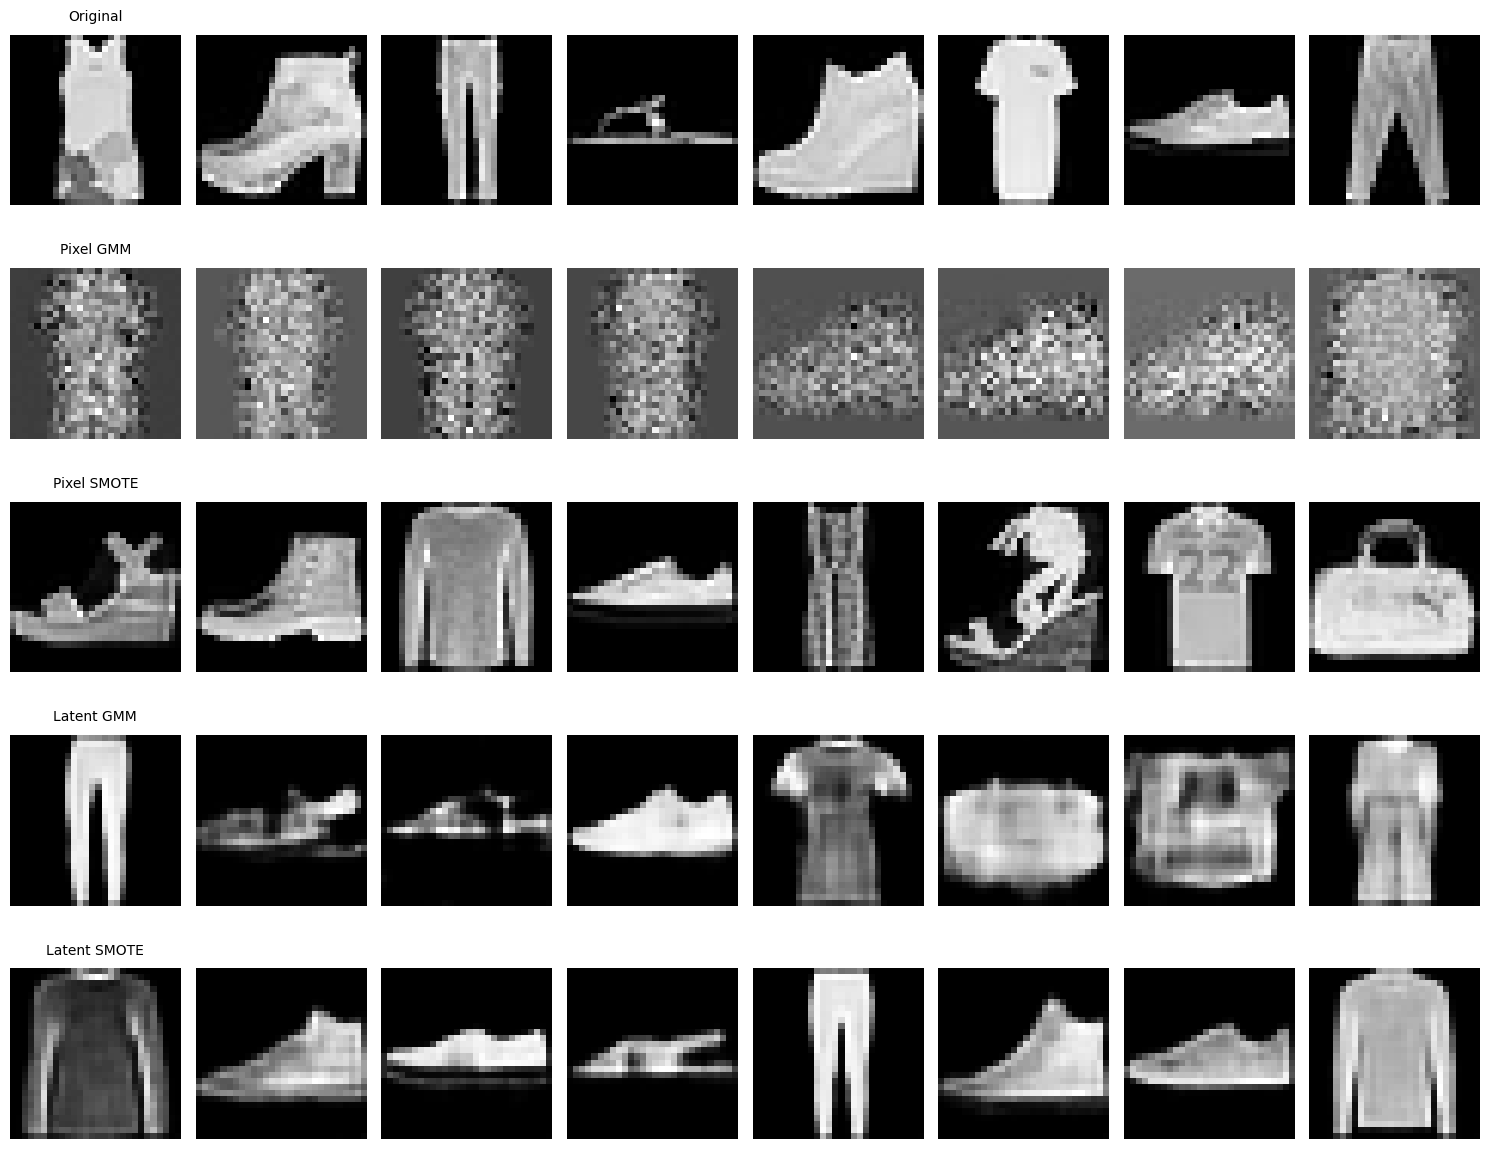

In [141]:
plt.figure(figsize=(15, 12))

for row, (title, imgs) in enumerate(labels_data):
    plt.subplot(5, 8, row * 8 + 1)
    plt.title(title, fontsize=10, pad=10)
    for i in range(8):
        idx = row * 8 + i + 1
        plt.subplot(5, 8, idx)
        img = imgs[i]
        if hasattr(img, "squeeze"):
            img = img.squeeze()
        plt.imshow(img, cmap='gray')
        plt.axis('off')

plt.tight_layout()
plt.show()

In [245]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, n_classes=10):
        super().__init__()
        self.label_emb = nn.Embedding(n_classes, n_classes)
        self.main = nn.Sequential(
            nn.Linear(latent_dim + n_classes, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        c = self.label_emb(labels)
        x = torch.cat([noise, c], dim=1)
        out = self.main(x)
        return out.view(-1, 1, 28, 28)

In [246]:
class Discriminator(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()
        self.label_emb = nn.Embedding(n_classes, n_classes)
        self.main = nn.Sequential(
            nn.Linear(784 + n_classes, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        c = self.label_emb(labels)
        img_flat = img.view(img.size(0), -1)
        x = torch.cat([img_flat, c], dim=1)
        return self.main(x)

In [227]:
latent_dim = 100
G = Generator(latent_dim).to(device)
D = Discriminator().to(device)
g_optim = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optim = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()

In [228]:
for epoch in range(30):
    for real_imgs, labels in train_loader:
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.to(device)
        labels = labels.to(device)

        d_optim.zero_grad()
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        output_real = D(real_imgs, labels)
        d_loss_real = criterion(output_real, real_labels)

        noise = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = G(noise, labels)
        output_fake = D(fake_imgs.detach(), labels)
        d_loss_fake = criterion(output_fake, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optim.step()

        g_optim.zero_grad()
        output = D(fake_imgs, labels)
        g_loss = criterion(output, real_labels)
        g_loss.backward()
        g_optim.step()
    print(f"Epoch {epoch+1}, D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")

Epoch 1, D_loss: 1.1295, G_loss: 1.3223
Epoch 2, D_loss: 1.1839, G_loss: 2.2287
Epoch 3, D_loss: 1.2607, G_loss: 1.1263
Epoch 4, D_loss: 1.1508, G_loss: 1.3491
Epoch 5, D_loss: 1.2902, G_loss: 1.0261
Epoch 6, D_loss: 1.2192, G_loss: 1.1005
Epoch 7, D_loss: 1.2357, G_loss: 1.2922
Epoch 8, D_loss: 1.2944, G_loss: 1.2413
Epoch 9, D_loss: 1.2923, G_loss: 1.1281
Epoch 10, D_loss: 1.2618, G_loss: 1.3330
Epoch 11, D_loss: 1.3485, G_loss: 0.9212
Epoch 12, D_loss: 1.3853, G_loss: 1.4432
Epoch 13, D_loss: 1.4053, G_loss: 0.8447
Epoch 14, D_loss: 1.3701, G_loss: 0.9607
Epoch 15, D_loss: 1.3319, G_loss: 0.8050
Epoch 16, D_loss: 1.3484, G_loss: 0.9180
Epoch 17, D_loss: 1.3318, G_loss: 0.7814
Epoch 18, D_loss: 1.3727, G_loss: 0.8352
Epoch 19, D_loss: 1.4124, G_loss: 0.8295
Epoch 20, D_loss: 1.3769, G_loss: 0.8094
Epoch 21, D_loss: 1.4076, G_loss: 0.7405
Epoch 22, D_loss: 1.3746, G_loss: 1.0081
Epoch 23, D_loss: 1.3305, G_loss: 0.8366
Epoch 24, D_loss: 1.3546, G_loss: 0.7459
Epoch 25, D_loss: 1.3585,

In [247]:
def plot_images(images, title, n=8):
    plt.figure(figsize=(n*2, 2))
    for i in range(n):
        plt.subplot(1, n, i+1)
        img = images[i].squeeze().cpu().numpy()
        plt.imshow(img, cmap='gray', vmin=-1, vmax=1)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

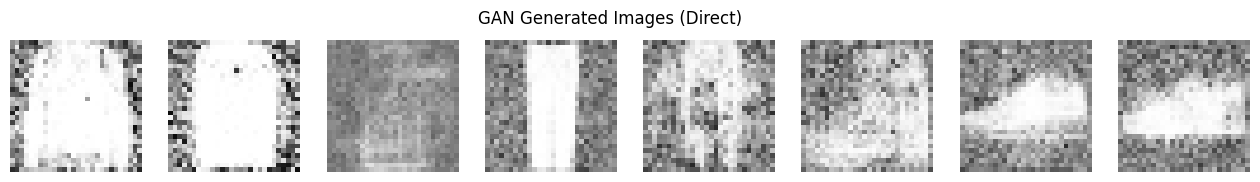

In [233]:
with torch.no_grad():
    noise = torch.randn(8, latent_dim).to(device)
    labels = torch.randint(0, 10, (8,)).to(device)
    gan_images = G(noise, labels)

plot_images(gan_images, "GAN Generated Images (Direct)")

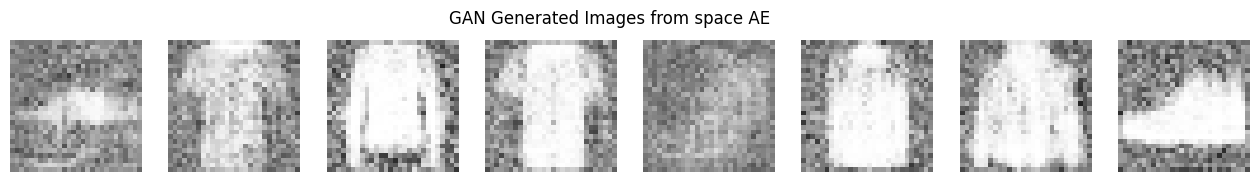

In [235]:
with torch.no_grad():
    for batch, label in train_loader:
        _, z_real = model(batch.to(device))
        class_labels = label[:8].to(device)
        break

    gan_ae_images = G(z_real[:8], class_labels)

plot_images(gan_ae_images, "GAN Generated Images from space AE")

In [236]:
def generate_by_class(class_idx, n=5):
    noise = torch.randn(n, latent_dim).to(device)
    labels = torch.full((n,), class_idx, dtype=torch.long).to(device)
    with torch.no_grad():
        generated = G(noise, labels)
    return generated

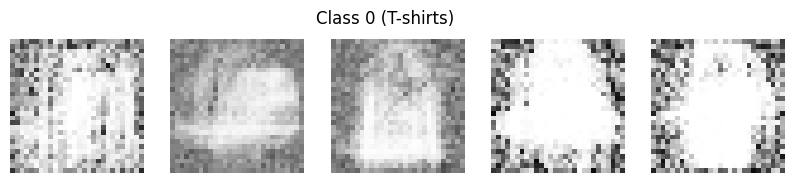

In [238]:
class_0 = generate_by_class(0)
plot_images(class_0, "Class 0 (T-shirts)", n=5)

In [243]:
def generate_mix(class_a, class_b, n=5, alpha=0.5):
    noise_a = torch.randn(n, latent_dim).to(device)
    noise_b = torch.randn(n, latent_dim).to(device)
    labels_a = torch.full((n,), class_a, dtype=torch.long).to(device)
    labels_b = torch.full((n,), class_b, dtype=torch.long).to(device)

    mixed_noise = alpha * noise_a + (1 - alpha) * noise_b
    mixed_labels = alpha * labels_a.float() + (1 - alpha) * labels_b.float()
    mixed_labels = mixed_labels.round().long()

    with torch.no_grad():
        images = G(mixed_noise, mixed_labels)

    return images


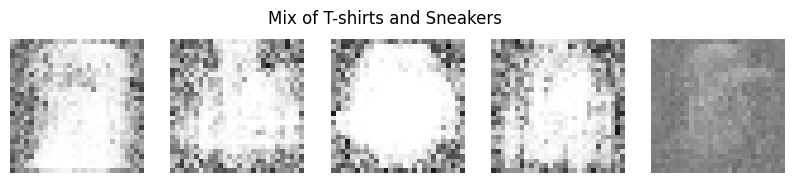

In [244]:
mix_images = generate_mix(0, 7)
plot_images(mix_images, "Mix of T-shirts and Sneakers", n=5)